> The notebook was used on kaggle but if the paths are properly defined, it can be used to train other image classification models on any ImageFolder dataset. The modular codes are available in the modular code folders. It just needs to be adapted for the specific task in mind. 

In [1]:
import torch

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed Feb 14 17:19:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: v2.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [5]:
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [6]:
input_folder = "/kaggle/input/african-wildlife"
output = "/kaggle/working/"

In [7]:
# importing split-folders to split my dataset
!pip install split-folders[full]

In [8]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output,
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

# Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
# splitfolders.fixed("input_folder", output="output",
#     seed=1337, fixed=(100, 100), oversample=False, group_prefix=None, move=False) # default values

Copying files: 3008 files [00:28, 106.19 files/s]


In [9]:
# Set up train and test dirs
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/val"

## Prepare Data

In [ ]:
import os

# remoing all the .txt file
# Replace with the actual path to your dataset directory
path_to_your_data = '/kaggle/working/'

# Walk through the directory
for root, dirs, files in os.walk(path_to_your_data):
    for file in files:
        # Check if the file is a .txt file
        if file.endswith('.txt'):
            # Construct the full file path
            path_to_file = os.path.join(root, file)
            # Remove the file
            os.remove(path_to_file)
        


# Get a Pretrained model

In [11]:
import torchvision
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.AlexNet_Weights.DEFAULT # best available weight
#transform = torchvision.models.AlexNet_Weights.IMAGENET1K_V1.transforms 
model_0 = torchvision.models.alexnet(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 172MB/s]  


In [12]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [32]:
# # Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    
])


In [34]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform= data_transform,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fcb52da3a30>,
 ['buffalo', 'elephant', 'rhino', 'zebra'])

In [35]:
summary(model_0,input_size = [32,3,224,224],col_names=["input_size","output_size","trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
AlexNet                                  [32, 3, 224, 224]         [32, 4]                   Partial
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 256, 6, 6]           False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 55, 55]          False
│    └─ReLU: 2-2                         [32, 64, 55, 55]          [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 55, 55]          [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 64, 27, 27]          [32, 192, 27, 27]         False
│    └─ReLU: 2-5                         [32, 192, 27, 27]         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 27, 27]         [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 192, 13, 13]         [32, 384, 13, 13]         False
│    └─ReLU: 2-8

In [36]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False
# Check summary again after
summary(model_0, input_size= [32,3,224,224],col_names= ["input_size","output_size","trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
AlexNet                                  [32, 3, 224, 224]         [32, 4]                   Partial
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 256, 6, 6]           False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 55, 55]          False
│    └─ReLU: 2-2                         [32, 64, 55, 55]          [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 55, 55]          [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 64, 27, 27]          [32, 192, 27, 27]         False
│    └─ReLU: 2-5                         [32, 192, 27, 27]         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 27, 27]         [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 192, 13, 13]         [32, 384, 13, 13]         False
│    └─ReLU: 2-8

In [37]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=9216,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Train Model

In [38]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
#print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

[INFO] Total training time: 422.101 seconds for 50 epochs.
Final test accuracy = 0.5197
Loss plateaued at a point

Make predictions on the entire test dataset with the model

In [40]:
len(test_dataloader)

9

In [45]:
from tqdm.auto import tqdm
model_0.eval()
test_preds = []
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        # move data to device
        X, y = X.to(device), y.to(device)
        # pass the data to the model
        test_logits = model_0(X)
        # get the probs using softmax
        pred_probs = torch.softmax(test_logits,dim=1)
        # get the class labels
        pred_probs_labels = torch.argmax(pred_probs,dim=1)
        # store in test_preds list
        test_preds.append(pred_probs_labels)

# concatenate to a tensor and take to cpu for further analysis
test_preds = torch.cat(test_preds).cpu()

  0%|          | 0/9 [00:00<?, ?it/s]

In [46]:
test_preds

tensor([2, 2, 2, 3, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 3, 2, 1, 0, 2, 0, 0, 3, 3,
        2, 3, 2, 0, 0, 0, 1, 2, 3, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0,
        3, 1, 1, 0, 1, 2, 1, 3, 0, 2, 2, 2, 3, 2, 1, 3, 1, 1, 3, 2, 1, 1, 2, 1,
        2, 3, 1, 2, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 3, 1,
        3, 3, 1, 3, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 2,
        2, 1, 0, 2, 2, 2, 3, 2, 2, 0, 1, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2,
        1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, 1, 2, 3, 3, 3, 2, 3,
        3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 1, 3, 3, 2, 1,
        0, 3, 3, 2, 3, 2, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 0,
        3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 0, 3, 3, 3, 2, 2, 3, 1, 2, 2, 1, 3, 2, 1,
        3, 2, 3, 2, 3, 1, 3, 0, 2, 3, 3, 2, 3, 3, 3, 1])

Make a confusion matrix with the test preds and the truth labels


In [47]:
y_test_true = [y for X,y in test_dataloader]
y_test_true

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [48]:
# Need to concatenate them
y_test_true = torch.cat(y_test_true)
y_test_true

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Need the following libraries to make a confusion matrix:

torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
mlxtend - http://rasbt.github.io/mlxtend/

In [49]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)

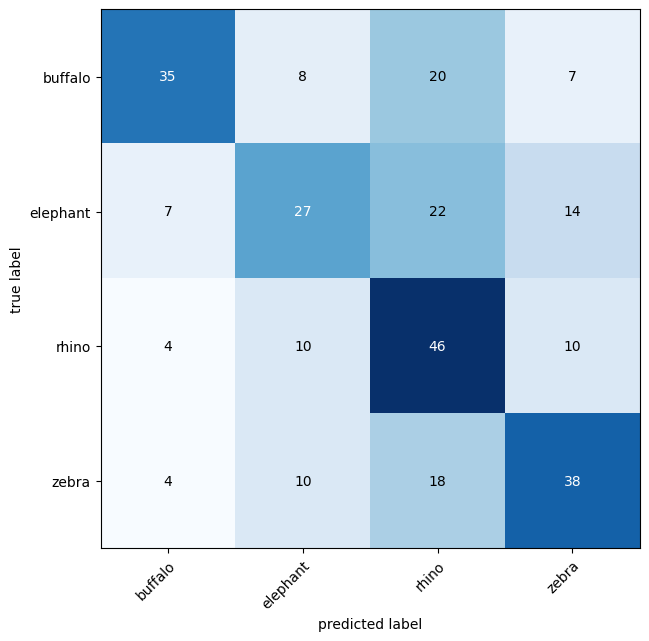

In [50]:
# TODO

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task= "multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=y_test_true)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

The metrics are just mid considering that the model is almost 300MB in size.

In [27]:
from torchvision import datasets
from torchvision import transforms 

# # Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1224
    Root location: /kaggle/working/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 280
    Root location: /kaggle/working/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [28]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fcb18440dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcb18442ce0>)

In [ ]:
# checking out model by doing a dummy forward pass: 
#Required when using a pretrained model as we may not know in advance the specific matrices dims
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")